# 1.1 Setup a Folder:

---






In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
import os
if not os.path.isdir("BrainTumor"):
  os.makedirs("BrainTumor")
%cd BrainTumor

/content/drive/MyDrive/BrainTumor


## 1.2 Donwloading DataSet:

---





In [3]:
!pip install opendatasets
import opendatasets as od
if not os.path.isdir("brain-tumor-mri-dataset"):
  od.download("https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 2.1 Exploring & Visualize The Data:

---






In [4]:
for folder in (os.listdir('brain-tumor-mri-dataset/Training')):
  print("The Number Of "+folder+"Images: "+str(len((os.listdir('brain-tumor-mri-dataset/Training/'+folder)))))

The Number Of gliomaImages: 1321
The Number Of meningiomaImages: 1339
The Number Of notumorImages: 1595
The Number Of pituitaryImages: 1457


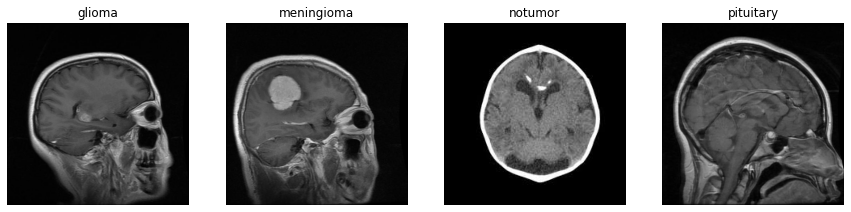

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
for number,folder in enumerate(os.listdir('brain-tumor-mri-dataset/Training')):
  names=os.listdir('brain-tumor-mri-dataset/Training/'+folder)
  indx=np.random.randint(len(names))
  img=plt.imread("brain-tumor-mri-dataset/Training/"+folder+"/"+str(names[indx]))
  plt.subplot(1,4,number+1)
  plt.imshow(img,cmap="gray")
  plt.title(str(folder))
  plt.axis('off')

## 2.2 Data Loading:

---






#### There Are 2 Ways To Load Data:

###### **1.In RAM**

In [ ]:
from matplotlib import image
import cv2
from tqdm import tqdm 
X_train=[]
Y_train=[]
for folder in os.listdir('brain-tumor-mri-dataset/Training'):
  files=os.listdir('brain-tumor-mri-dataset/Training/'+folder)
  for file in tqdm(files):
    image=cv2.imread(f"brain-tumor-mri-dataset/Training/{folder}/{file}",0)
    image=cv2.resize(image,(150,150))
    X_train.append(image)
    Y_train.append(str(folder))

100%|██████████| 1457/1457 [00:47<00:00, 30.38it/s] 


In [ ]:
from tqdm import tqdm 
X_test=[]
Y_test=[]
for folder in os.listdir('brain-tumor-mri-dataset/Training'):
  files=os.listdir('brain-tumor-mri-dataset/Testing/'+folder)
  for file in tqdm(files):
    image=cv2.imread(f"brain-tumor-mri-dataset/Testing/{folder}/{file}",0)
    image=cv2.resize(image,(150,150))
    X_test.append(image)
    Y_test.append(str(folder))

100%|██████████| 300/300 [00:05<00:00, 58.08it/s] 


###### **2.From Disk**


Batch By Batch In Ram From Disk By Using 'ImageDataGenerator' in Keras

In [15]:
from keras.preprocessing.image import ImageDataGenerator
Size=100
B_size=16
Training_path='brain-tumor-mri-dataset/Training'
train_datagen=ImageDataGenerator(rescale=1./255)
train_generator=train_datagen.flow_from_directory(Training_path,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=B_size,
    target_size=(Size,Size))

Found 5712 images belonging to 4 classes.


(-0.5, 99.5, 99.5, -0.5)

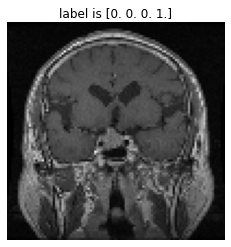

In [16]:
#Viz Data From Generator
Image,Y=next(train_generator)
plt.imshow(Image[0],cmap="gray")
plt.title("label is "+str(Y[0]))
plt.axis('off')

In [17]:
Testing_path='brain-tumor-mri-dataset/Testing'
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_directory(Testing_path,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=B_size,
    target_size=(Size,Size))

Found 1311 images belonging to 4 classes.


(-0.5, 99.5, 99.5, -0.5)

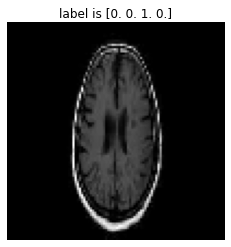

In [18]:
#Viz Data From Generator
Image,Y=next(test_generator)
plt.imshow(Image[0],cmap="gray")
plt.title("label is "+str(Y[0]))
plt.axis('off')

In [33]:
class_indices = test_generator.class_indices
print(class_indices)  

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [34]:
label_to_class = {v: k for k, v in class_indices.items()}
print(label_to_class)

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


# 3.1 Create Model:

---



In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras.utils import plot_model 

In [19]:
model=Sequential([
    Conv2D(32,3,activation='relu',input_shape=(Size,Size,1)),
    Conv2D(32,3,activation='relu'),
    MaxPooling2D((2,2)),
    BatchNormalization(),
    Dropout(.2),
    
    Conv2D(16,3,activation='relu'),
    Conv2D(16,3,activation='relu'),
    MaxPooling2D((2,2)),
    BatchNormalization(),
    Dropout(.2),
    
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(.2),
    Dense(128,activation='relu'),
    Dense(4,activation='softmax')])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 48, 48, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 16)       

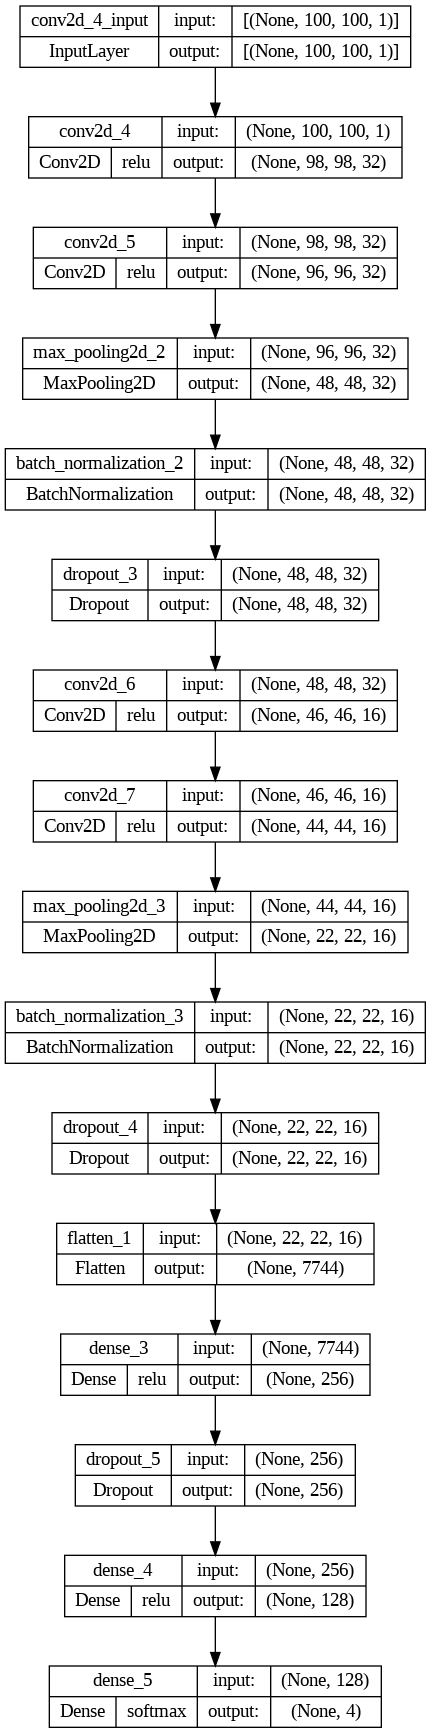

In [20]:
plot_model(model,show_shapes=True,expand_nested=True,show_layer_activations=True)

In [21]:
#model compilation:
model.compile(optimizer ="Adam",loss='categorical_crossentropy',metrics= ['accuracy'])

# 3.2 Trainning:

---



In [22]:
epoch=50
steps=int(len(train_generator)/B_size)
model.fit(train_generator,
              epochs=epoch,
              steps_per_epoch=steps)

Epoch 1/50
22/22 [==============================] - 74s 3s/step - loss: 1.2999 - accuracy: 0.5511
Epoch 2/50
22/22 [==============================] - 60s 3s/step - loss: 0.8378 - accuracy: 0.7244
Epoch 3/50
22/22 [==============================] - 56s 3s/step - loss: 0.7824 - accuracy: 0.7273
Epoch 4/50
22/22 [==============================] - 55s 3s/step - loss: 0.7558 - accuracy: 0.7074
Epoch 5/50
22/22 [==============================] - 51s 2s/step - loss: 0.5858 - accuracy: 0.7812
Epoch 6/50
22/22 [==============================] - 46s 2s/step - loss: 0.5387 - accuracy: 0.8182
Epoch 7/50
22/22 [==============================] - 45s 2s/step - loss: 0.6386 - accuracy: 0.7415
Epoch 8/50
22/22 [==============================] - 44s 2s/step - loss: 0.5210 - accuracy: 0.7528
Epoch 9/50
22/22 [==============================] - 41s 2s/step - loss: 0.5302 - accuracy: 0.7983
Epoch 10/50
22/22 [==============================] - 37s 2s/step - loss: 0.5369 - accuracy: 0.8040
Epoch 11/50
22/22 [

In [27]:
epoch=20
steps=int(len(train_generator)/B_size)
model.fit(train_generator,
              epochs=epoch,
              steps_per_epoch=steps)

Epoch 1/20
22/22 [==============================] - 2s 82ms/step - loss: 0.1054 - accuracy: 0.9631
Epoch 2/20
22/22 [==============================] - 2s 100ms/step - loss: 0.0819 - accuracy: 0.9688
Epoch 3/20
22/22 [==============================] - 2s 99ms/step - loss: 0.0865 - accuracy: 0.9688
Epoch 4/20
22/22 [==============================] - 2s 79ms/step - loss: 0.0786 - accuracy: 0.9773
Epoch 5/20
22/22 [==============================] - 2s 71ms/step - loss: 0.0658 - accuracy: 0.9744
Epoch 6/20
22/22 [==============================] - 2s 68ms/step - loss: 0.0709 - accuracy: 0.9773
Epoch 7/20
22/22 [==============================] - 2s 81ms/step - loss: 0.0596 - accuracy: 0.9801
Epoch 8/20
22/22 [==============================] - 4s 183ms/step - loss: 0.0671 - accuracy: 0.9801
Epoch 9/20
22/22 [==============================] - 3s 112ms/step - loss: 0.0397 - accuracy: 0.9858
Epoch 10/20
22/22 [==============================] - 2s 76ms/step - loss: 0.0461 - accuracy: 0.9830
Epoch 

# 3.3 Evaluation & Prediction :

---



In [28]:
test_steps=int(len(test_generator)/B_size)
model.evaluate(test_generator,steps=test_steps)

5/5 [==============================] - 9s 2s/step - loss: 0.1552 - accuracy: 0.9625


[0.15524813532829285, 0.9624999761581421]

1/1 [==============================] - 0s 22ms/step


(-0.5, 511.5, 511.5, -0.5)

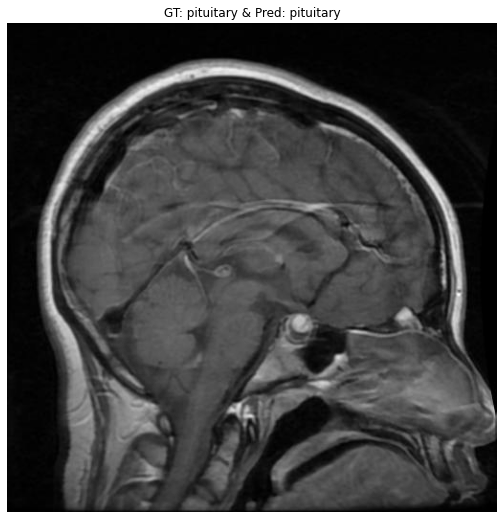

In [41]:
#predicting:
image,Y_GT=next(test_generator)

image=np.expand_dims(image[0],axis=0)
y_pred=model.predict(image)
Y_pred=label_to_class[np.argmax(y_pred)]

%matplotlib inline
plt.figure(figsize=(20,9))
plt.imshow(img,cmap='gray')
plt.title(f"GT: {label_to_class[np.argmax(Y_GT[0])]} & Pred: {label_to_class[np.argmax(y_pred)]}")
plt.axis("off")
